In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
#!pip -q install cdxbasics "tensorflow>=2.11" "tensorflow_probability==0.19"
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
my_path = None
if i!=-1:
    my_path = p[:i]
    import sys
    sys.path.append(my_path)
    print("SageMaker: added python path %s" % my_path)
else:
    print(sys.path)

SageMaker: added python path /Users/lisafaloughi/Desktop/DeepHedging


## Black Scholes

Initializing training at 2025-05-04 11:36:06: gym with 102 trainable weights compiled. Took 0s
ProtoAgent using 100 trainable weights for 1 instruments.
Features used: delta, price and time_left
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/proto_100/dd313b0faa453461c720965bf2f0bf20909c1846c4dc8dfa.pck'
Cache successfully loaded. Current epoch: 800
Nothing to do: cached model loaded from /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/proto_100/dd313b0faa453461c720965bf2f0bf20909c1846c4dc8dfa.pck was trained for 800 epochs; you have asked to train for 800 epochs. If you want to force training: raise number of epochs or turn off caching.
Plotting results for the trained model.
Training monitor initialized. Took 0s
                                  

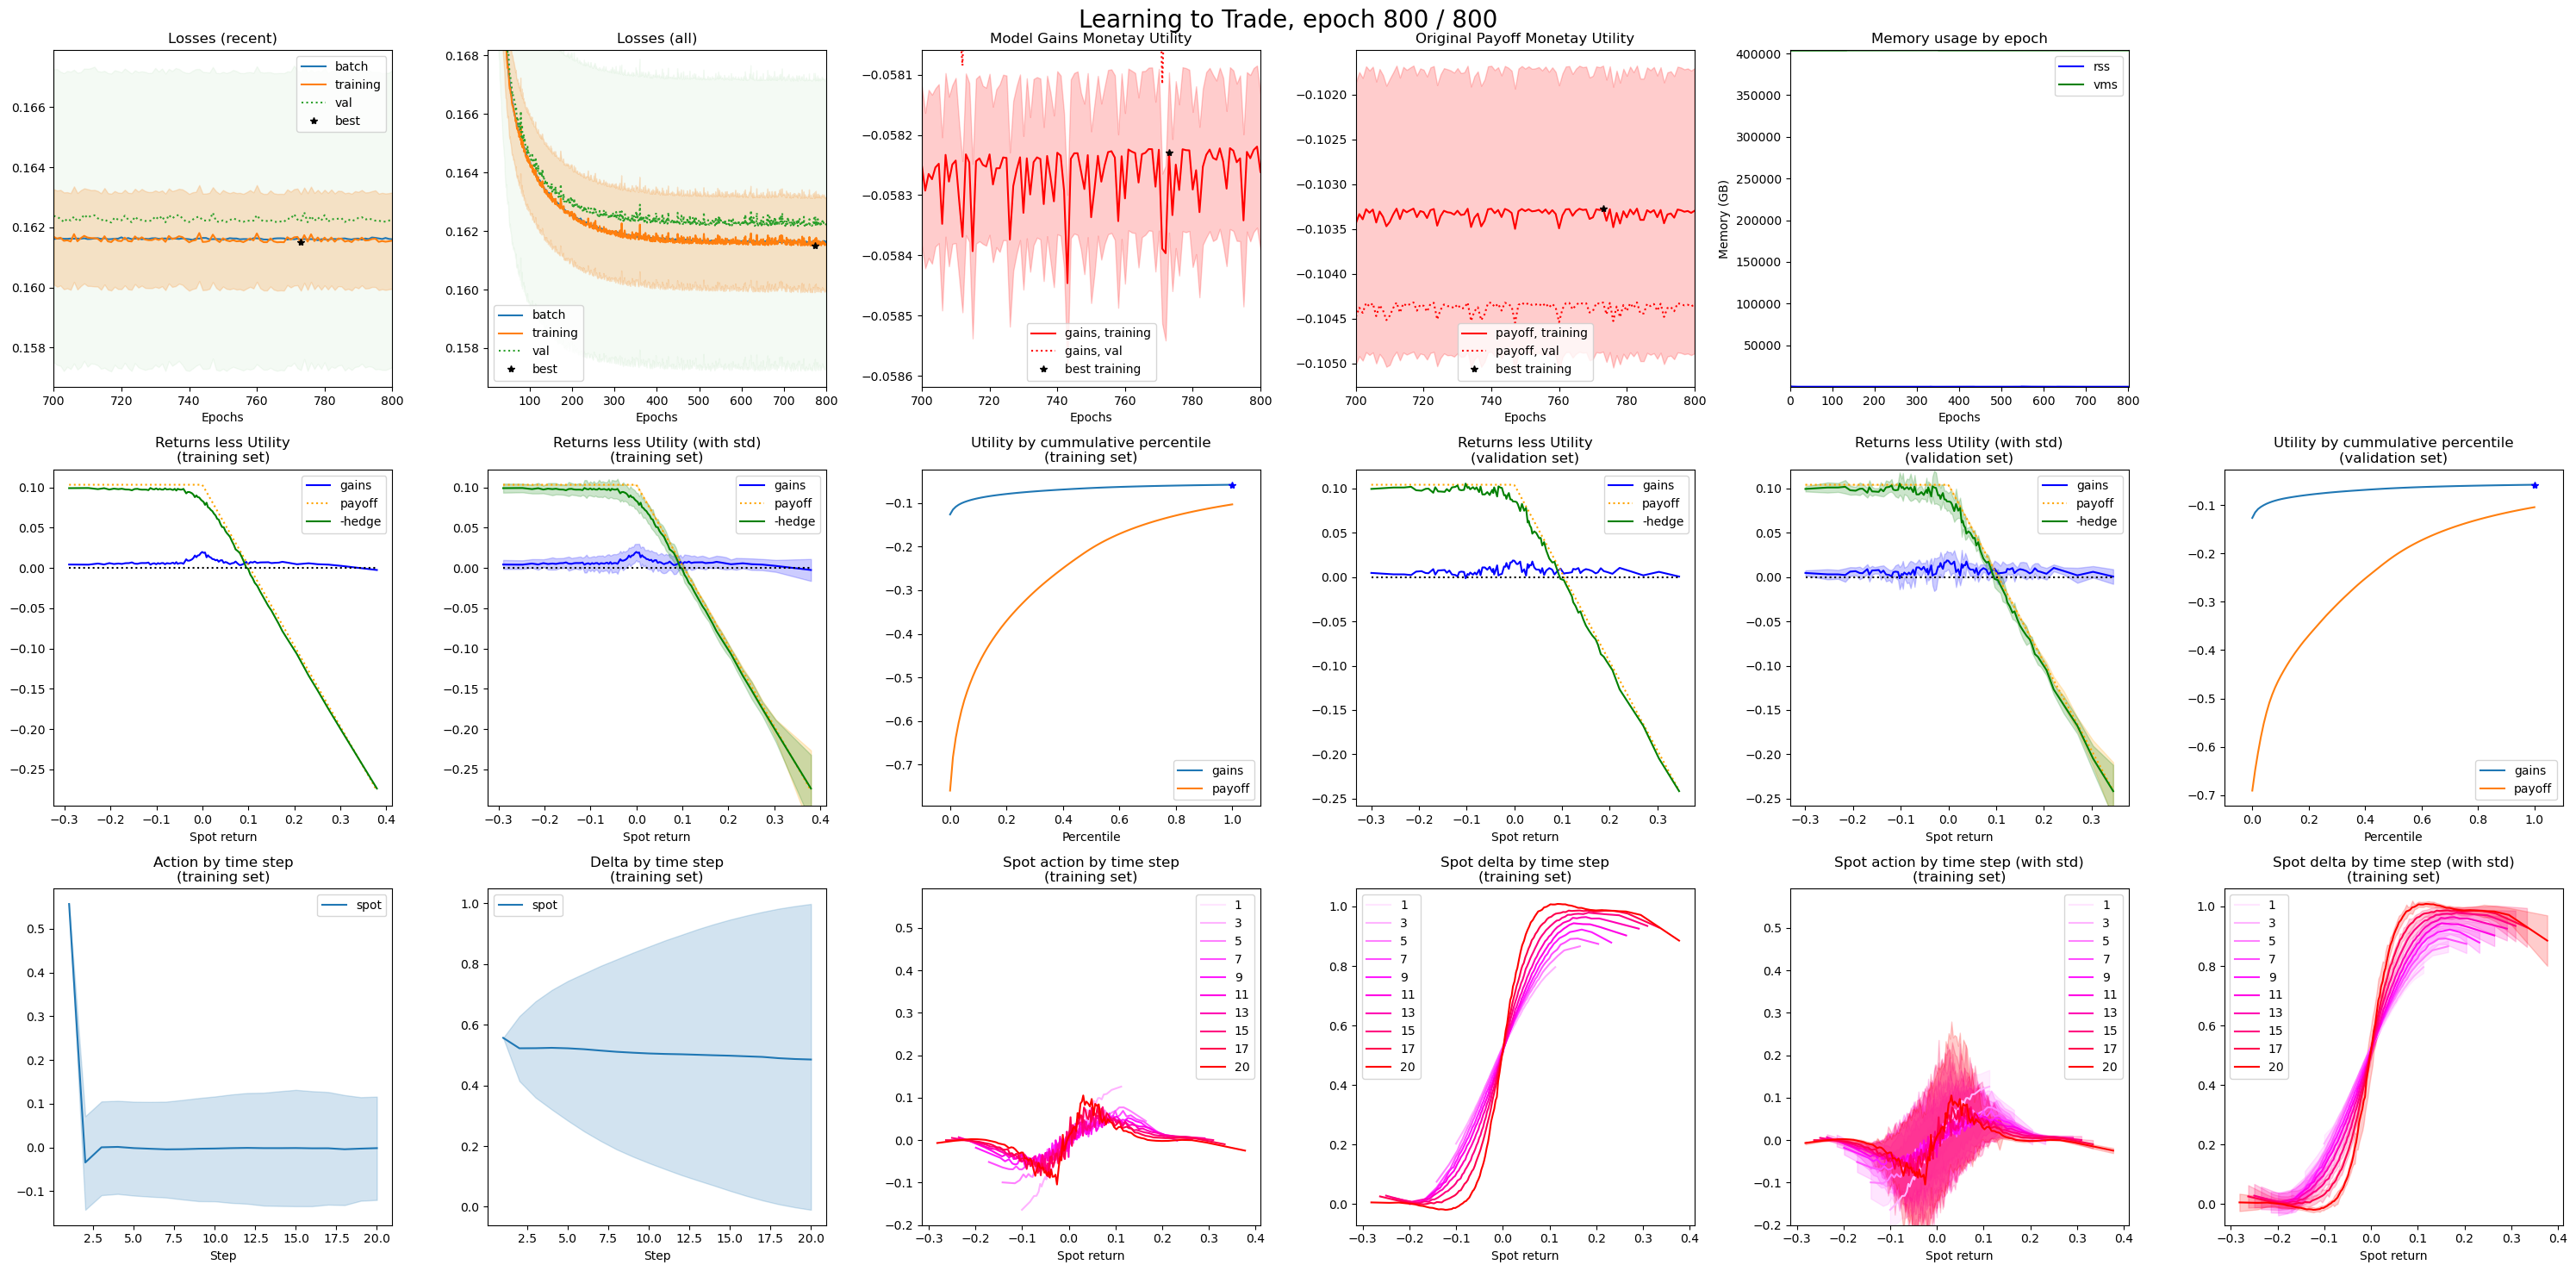

Training 800/800 epochs; 102 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 0.675493 (0.0103786), training 0.161557 (0.00160502), best 0.161501 (0.0103786), batch 0.161602, val 0.162286 (0.00494239); best epoch 773, last cached 800 | memory used: rss 156.812M, vms 403839M | time elapsed 50:59; time per epoch 3s; estimated time remaining 0s | current time: 2025-05-04 11:36:09                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 773
 State of training until epoch 800 cached into /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/proto_100/dd313b0faa453461c720965bf2f0bf20909c1846c4dc8dfa.pck
 Time: 2025-05-04 11:36:10
Training terminated. Total time taken 4s
Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
Config usage report
config.gym.agent['agent_type'] = protopnet # Which network agent type t

In [4]:
# In your notebook or training script:

import pickle
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.trainer import train
from deephedging.world import SimpleWorld_Spot_ATM
from cdxbasics.config import Config

# 1. Load configuration
config = Config()
n_prototypes = 100 

# 2. World setup
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True

# 3. Gym setup with ProtoAgent
config.gym.agent.agent_type = "protopnet"  # Tells AgentFactory to use ProtoAgent
config.gym.agent.features = ["price", "delta", "time_left"]  # Must match prototype dimensions
config.gym.agent.prototype_path = f"./prototypes_{n_prototypes}.pkl"

config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.

# 4. Load saved prototypes (used inside ProtoPNetLayer)
with open(f"./prototypes_{n_prototypes}.pkl", "rb") as f:
    prototypes = pickle.load(f)

# 5. Trainer config
config.trainer.train.epochs = 800
config.trainer.caching.directory = f"./.deephedging_cache/proto_{n_prototypes}"

config.trainer.caching.mode = "on"  # Important to avoid reusing old cache
config.trainer.visual.epoch_refresh = 30

config.trainer.train.optimizer.name = "adam"

config.trainer.train.batch_size = None
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

# 6. Build world & val_world
world = SimpleWorld_Spot_ATM(config.world)
val_world = world.clone(samples=world.nSamples // 10)

# 7. Create the gym (automatically uses ProtoAgent via AgentFactory)
gym = VanillaDeepHedgingGym(config.gym)

# 8. Train the model using the prototype-based agent
train(gym=gym, world=world, val_world=val_world, config=config.trainer)

r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

## Training (Black Scholes = True)

## Inference

In [8]:
import tensorflow as tf
import numpy as np

agent = gym.agent
agent.print_sample_prototypes([42]) 


Prototype 42: Features = [-0.15125117 -0.02707677  0.60697705], Action = [8.566829]


In [6]:
# 1. Generate 5000 new test samples from same world
test_world = world.clone(samples=5000)
test_result = gym(test_world.tf_data)

In [10]:
# 2. Extract model input features
price      = test_world.data.features.per_step['price'][0]       # shape (20,)
time_left  = test_world.data.features.per_step['time_left'][0]   # shape (20,)
actions    = test_result['actions'][0].numpy().flatten()         # shape (20,)

# 3. Reconstruct delta from cumulative actions
delta = np.concatenate([[0], np.cumsum(actions[:-1])])  # shape (20,)
# 4. Stack into feature vectors (must be in [delta, price, time_left] order)
X = np.stack([delta, price, time_left], axis=1)  # shape (20, 3)

# 5. Apply scaler (the one saved with prototypes)
from pickle import load
with open(f"./prototypes_{n_prototypes}.pkl", "rb") as f:
    data = load(f)
scaler = data["scaler"]
X_scaled = scaler.transform(X)

# 6. Get model components
proto_layer = gym.agent.proto_layer
prototypes = proto_layer.prototypes.numpy()
proto_actions = proto_layer.prototype_actions.numpy()

# 7. Compute distances, similarities, and closest prototypes
x_tf = tf.convert_to_tensor(X_scaled, dtype=tf.float32)
x_exp = tf.expand_dims(x_tf, axis=1)                         # [20, 1, 3]
p_exp = tf.expand_dims(proto_layer.prototypes, axis=0)       # [1, 500, 3]
distances = tf.reduce_sum((x_exp - p_exp) ** 2, axis=2)      # [20, 500]
similarities = tf.nn.softmax(-distances, axis=1)             # [20, 500]
closest = tf.argmax(similarities, axis=1).numpy()            # [20]

# 8. Display step-by-step explanation
for t in range(20):
    top3_idx = np.argsort(-similarities[t].numpy())[:3]
    print(f"\nStep {t}:")
    print(f"  Input:        delta={delta[t]:.3f}, price={price[t]:.3f}, time_left={time_left[t]:.3f}")
    print(f"  Action:       {actions[t]:.4f}")
    print(f"  Top 3 Prototypes:")
    for idx in top3_idx:
        raw_features = scaler.inverse_transform([prototypes[idx]])[0]
        print(f"    • Prototype {idx} | Features={raw_features.round(3)} | Action={proto_actions[idx].round(3)} | Similarity={similarities[t, idx].numpy():.3f}")


Step 0:
  Input:        delta=0.000, price=1.000, time_left=0.400
  Action:       0.5568
  Top 3 Prototypes:
    • Prototype 4 | Features=[-0.   1.   0.4] | Action=[4.884] | Similarity=0.499
    • Prototype 71 | Features=[0.368 0.972 0.32 ] | Action=[7.165] | Similarity=0.061
    • Prototype 16 | Features=[0.313 0.929 0.32 ] | Action=[2.113] | Similarity=0.053

Step 1:
  Input:        delta=0.557, price=1.009, time_left=0.380
  Action:       -0.0109
  Top 3 Prototypes:
    • Prototype 68 | Features=[0.557 1.021 0.38 ] | Action=[2.282] | Similarity=0.077
    • Prototype 32 | Features=[0.557 0.993 0.38 ] | Action=[-0.353] | Similarity=0.076
    • Prototype 0 | Features=[0.597 1.004 0.34 ] | Action=[-2.234] | Similarity=0.068

Step 2:
  Input:        delta=0.546, price=0.984, time_left=0.360
  Action:       -0.0714
  Top 3 Prototypes:
    • Prototype 32 | Features=[0.557 0.993 0.38 ] | Action=[-0.353] | Similarity=0.066
    • Prototype 10 | Features=[0.464 0.978 0.36 ] | Action=[3.223] |

Why are most payoff = 0? because the payoff = -np.maximum(spots[:, -1] - 1.0, 0.0) ; This corresponds to a short European call option with strike 1, so:

	•	When S_T ≤ 1.0, payoff = 0
	•	When S_T > 1.0, payoff = negative

If the model dynamics result in many paths ending below or near 1, most payoffs will be -0.

Number of zero payoffs: 2621 / 5000


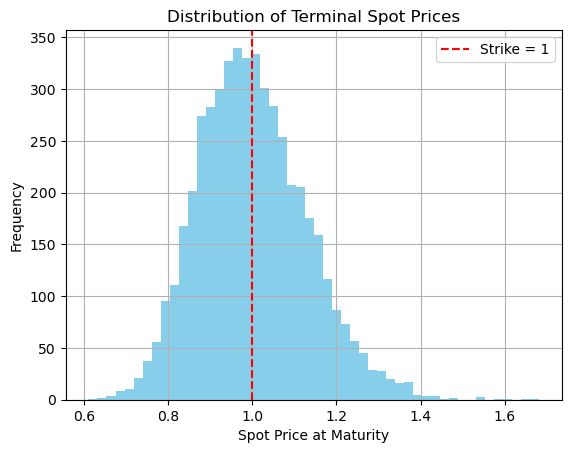

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Get terminal spot prices
terminal_spots = test_world.details.spot_all[:, -1]

# 2. Get payoffs
payoffs = test_result["payoff"].numpy()

# 3. Check how many are exactly -0 (or close)
n_zero_payoffs = np.sum(np.isclose(payoffs, 0))
print(f"Number of zero payoffs: {n_zero_payoffs} / {len(payoffs)}")

# 4. Plot histogram of terminal spot prices
plt.hist(terminal_spots, bins=50, color="skyblue")
plt.axvline(1.0, color="red", linestyle="--", label="Strike = 1")
plt.title("Distribution of Terminal Spot Prices")
plt.xlabel("Spot Price at Maturity")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()

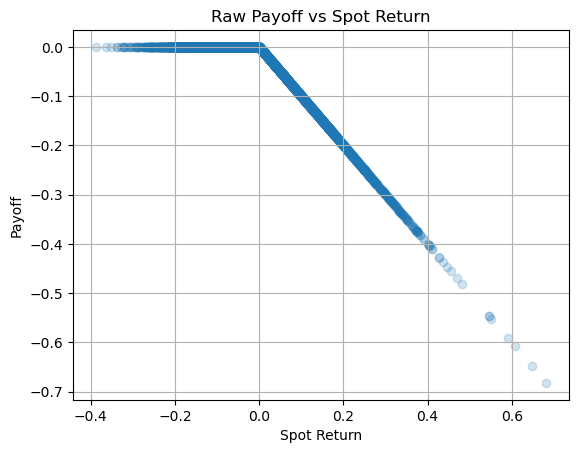

In [12]:
spot_return = test_world.details.spot_all[:, -1] - 1.0
payoff = test_result["payoff"].numpy()

import matplotlib.pyplot as plt
plt.scatter(spot_return, payoff, alpha=0.2)
plt.xlabel("Spot Return")
plt.ylabel("Payoff")
plt.title("Raw Payoff vs Spot Return")
plt.grid(True)
plt.show()

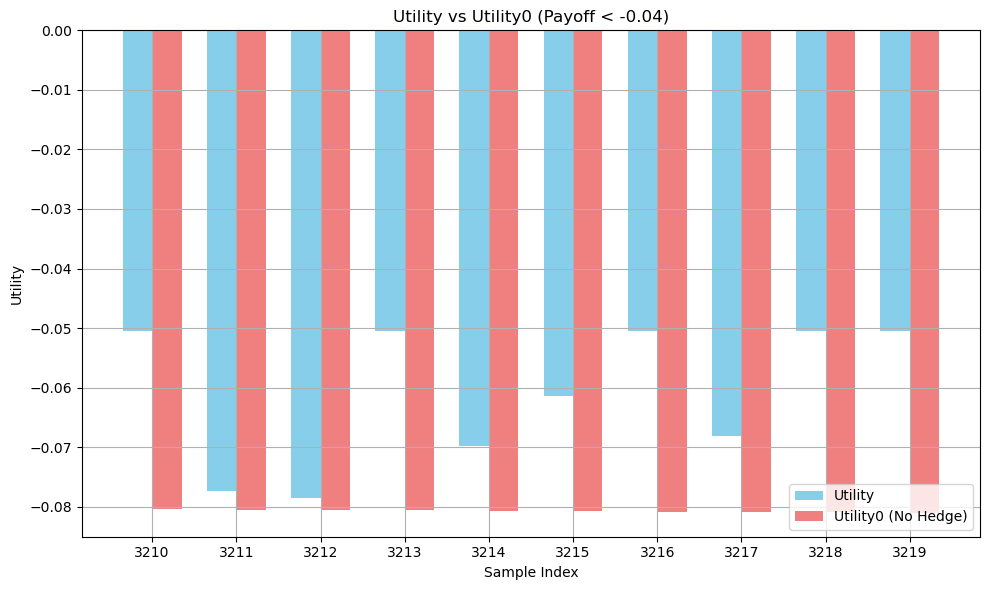

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Extract utility, utility0, and payoff
utility = test_result["utility"].numpy()
utility0 = test_result["utility0"].numpy()
payoff = test_result["payoff"].numpy()

# Find indices where payoff < 0 (i.e., short option was exercised)
negative_payoff_indices = np.where(payoff < -0.04)[0]

# Take the first 10 of those
selected_indices = negative_payoff_indices[:10]
if len(selected_indices) == 0:
    print("No samples with payoff < -0.04 found.")
else:
    bar_width = 0.35
    indices = np.arange(len(selected_indices))

    plt.figure(figsize=(10, 6))
    plt.bar(indices, utility[selected_indices], width=bar_width, label='Utility', color='skyblue')
    plt.bar(indices + bar_width, utility0[selected_indices], width=bar_width, label='Utility0 (No Hedge)', color='lightcoral')

    plt.xlabel("Sample Index")
    plt.ylabel("Utility")
    plt.title("Utility vs Utility0 (Payoff < -0.04)")
    plt.xticks(indices + bar_width / 2, [str(i) for i in selected_indices])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Visualisations

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Step 1: Run model on many test paths
test_world = world.clone(samples=5000)
result = gym(test_world.tf_data)

# Step 2: Extract features from world and actions from result
price = test_world.data.features.per_step['price']       # shape: [5000, 20]
time_left = test_world.data.features.per_step['time_left']
actions = result['actions'].numpy().squeeze()            # shape: [5000, 20]

# Step 3: Build [B*T, 3] feature matrix in correct sorted order
B, T = price.shape
delta = np.concatenate([np.zeros((B, 1)), np.cumsum(actions[:, :-1], axis=1)], axis=1)
X = np.stack([delta, price, time_left], axis=2).reshape(-1, 3)  # [B*T, 3]

# Step 4: Apply saved scaler
with open(f"./prototypes_{n_prototypes}.pkl", "rb") as f:
    data = pickle.load(f)
scaler = data["scaler"]
X_scaled = scaler.transform(X)

# Step 5: Compute closest prototypes
proto_layer = gym.agent.proto_layer
x_tf = tf.convert_to_tensor(X_scaled, dtype=tf.float32)  # [B*T, 3]
x_exp = tf.expand_dims(x_tf, axis=1)                     # [B*T, 1, 3]
p_exp = tf.expand_dims(proto_layer.prototypes, axis=0)   # [1, P, 3]
distances = tf.reduce_sum((x_exp - p_exp)**2, axis=2)    # [B*T, P]
similarities = tf.nn.softmax(-distances, axis=1)         # [B*T, P]
closest = tf.argmax(similarities, axis=1).numpy()        # [B*T]

# Step 6: Reshape to [B, T] and count usage
closest_matrix = closest.reshape(B, T)                   # [B, T]
n_prototypes = proto_layer.prototypes.shape[0]
heatmap = np.zeros((n_prototypes, T))
for t in range(T):
    unique, counts = np.unique(closest_matrix[:, t], return_counts=True)
    heatmap[unique, t] = counts

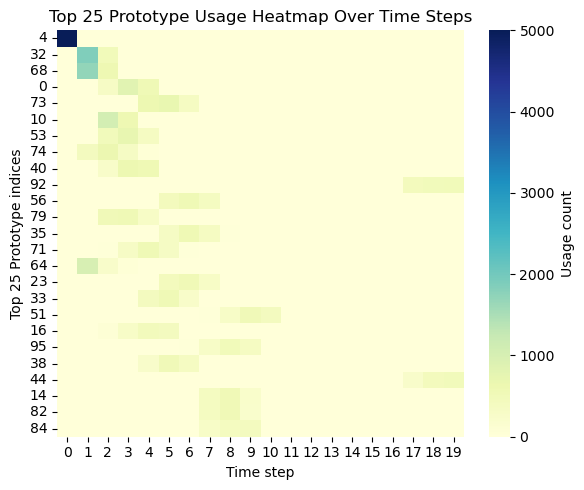

In [16]:
# Step 7: Compute total usage per prototype and get top 25
totals = np.sum(heatmap, axis=1)                            # total use per prototype
top_indices = np.argsort(totals)[-25:][::-1]               # top 25 in descending order
filtered_heatmap = heatmap[top_indices]                     # filter rows
filtered_indices = top_indices                              # for labeling y-axis

# Step 8: Plot top 25 prototype usage
plt.figure(figsize=(6, 5))
sns.heatmap(filtered_heatmap, cmap="YlGnBu", cbar_kws={'label': 'Usage count'}, yticklabels=filtered_indices)
plt.xlabel("Time step")
plt.ylabel("Top 25 Prototype indices")
plt.title("Top 25 Prototype Usage Heatmap Over Time Steps")
plt.tight_layout()
plt.show()

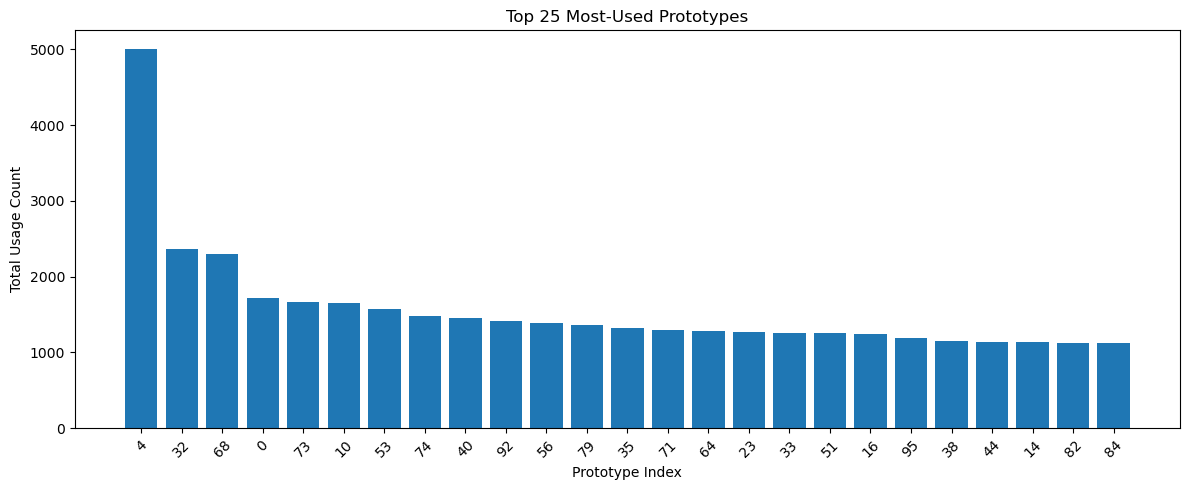

In [17]:
# Step 1: Compute total usage again
totals = np.sum(heatmap, axis=1)                             # [num_prototypes]
top_25_idx = np.argsort(totals)[-25:][::-1]                  # indices of top 25
top_25_vals = totals[top_25_idx]

# Step 2: Bar chart
plt.figure(figsize=(12, 5))
plt.bar(range(25), top_25_vals, tick_label=top_25_idx)
plt.xlabel("Prototype Index")
plt.ylabel("Total Usage Count")
plt.title("Top 25 Most-Used Prototypes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

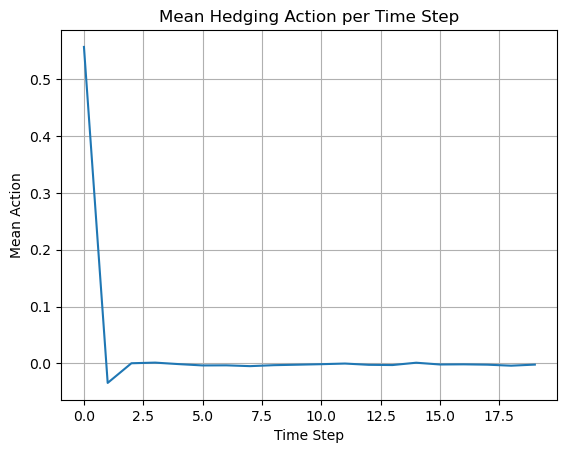

In [18]:
import matplotlib.pyplot as plt
import numpy as np

actions = result["actions"].numpy()  # shape 

# Compute mean over all  scenarios → shape (20,)
mean_actions = actions.mean(axis=0).squeeze()

# Plot
plt.plot(mean_actions)
plt.title("Mean Hedging Action per Time Step")
plt.xlabel("Time Step")
plt.ylabel("Mean Action")
plt.grid(True)
plt.show()

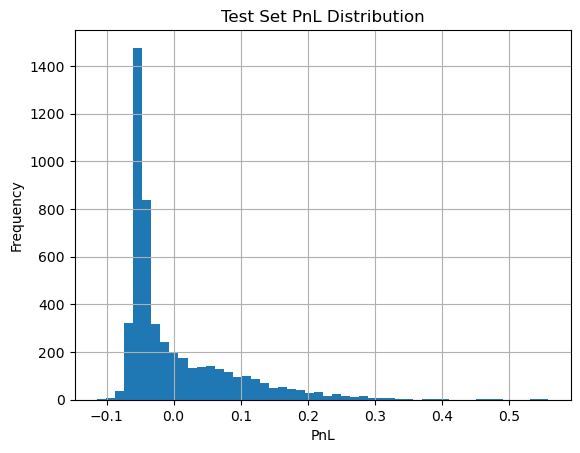

In [19]:
plt.hist(test_result["pnl"].numpy(), bins=50)
plt.title("Test Set PnL Distribution")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [20]:
import numpy as np

utility = result["utility"].numpy()
utility0 = result["utility0"].numpy()

# Count how many times utility > utility0
n_better = np.sum(utility > utility0)
total = len(utility)

print(f"Utility is higher than Utility0 in {n_better} out of {total} samples ({n_better / total:.2%})")

Utility is higher than Utility0 in 1980 out of 5000 samples (39.60%)


In [21]:
print("Mean Utility (unhedged):", test_result["utility0"].numpy().mean())
print("Mean Utility (hedged):", test_result["utility"].numpy().mean())
print("payoff", test_result["payoff"].numpy().mean())
print("gains", test_result["gains"].numpy().mean())
print("pnl", test_result["pnl"].numpy().mean())


Mean Utility (unhedged): -0.104581065
Mean Utility (hedged): -0.058142602
payoff -0.05228948
gains -0.050676342
pnl 0.0019891753


## Stochastic -NEW PROTOTYPE NO INITIAL DELTA

## Stochastic Vol
### Trading with two assets

Deep Hedging AI says hello  ... 

## Deep Hedging in a simple Stochastic Volatility World

Initializing training at 2025-05-04 11:43:11: gym with 3002 trainable weights compiled. Took 1s
ProtoAgent using 3000 trainable weights for 2 instruments.
Features used: delta, price and time_left
Monetary utility cvar@1 is using 1 weight
 Features available: call_delta, call_price, call_vega, cost, cost_v, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/proto_stochastic1500/2fc01f27f9577fa501db565811893f75de06c8611ea9d862.pck'
Cache successfully loaded. Current epoch: 800
Nothing to do: cached model loaded from /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/proto_stochastic1500/2fc01f27f9577fa501db565811893f75de06c8611ea9d862.pck was trained for 800 epochs; you have asked to train for 800 epochs. If you want to force training: raise number of epochs or turn off caching.
Plotting results for the trained model.
Train

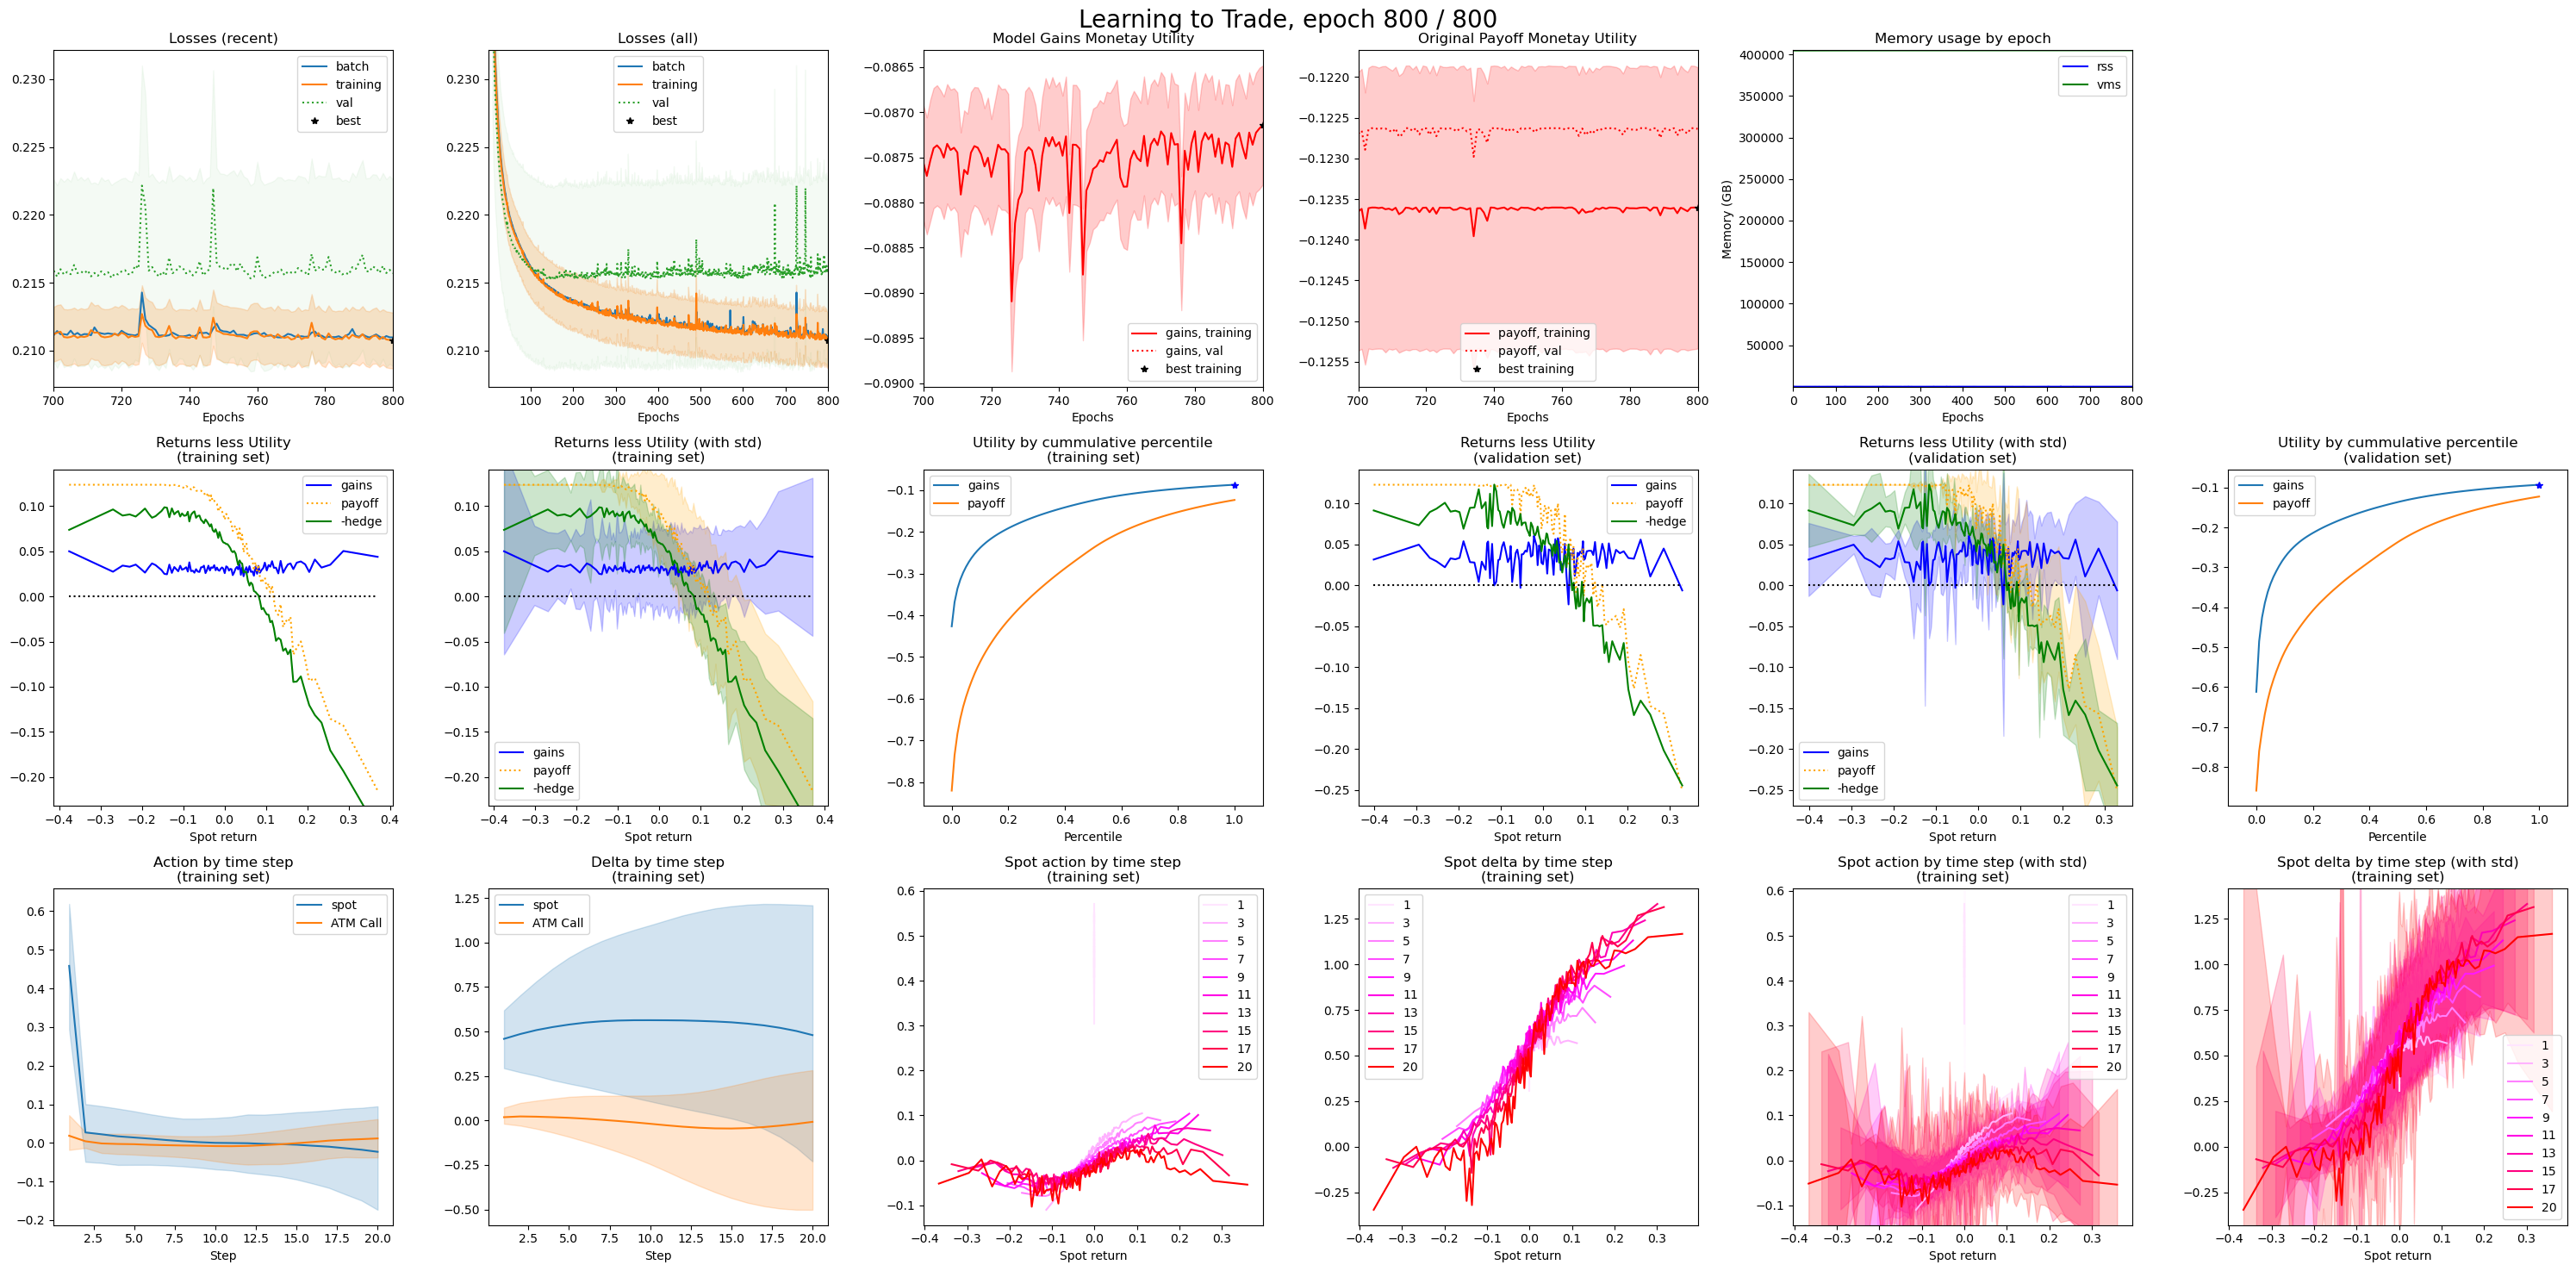

Training 800/800 epochs; 3002 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 0.783839 (0.0110673), training 0.210749 (0.00205222), best 0.210749 (0.0110673), batch 0.21098, val 0.215712 (0.00687105); best epoch 800, last cached 800 | memory used: rss 268.031M, vms 404873M | time elapsed 2:57:50; time per epoch 13s; estimated time remaining 0s | current time: 2025-05-04 11:43:15                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 800
 State of training until epoch 800 cached into /Users/lisafaloughi/Desktop/DeepHedging/deephedging/notebooks/.deephedging_cache/proto_stochastic1500/2fc01f27f9577fa501db565811893f75de06c8611ea9d862.pck
 Time: 2025-05-04 11:43:16
Training terminated. Total time taken 5s
Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
Config usage report
config.gym.agent['agent_type'] = protopnet # Which networ

In [24]:
print("Deep Hedging AI says hello  ... ", end='')
import pickle
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.trainer import train
from deephedging.world import SimpleWorld_Spot_ATM
from cdxbasics.config import Config
from IPython.display import display, Markdown
# ============================
# 1. Load configuration
config = Config()

n_prototypes = 1500

# 2. World setup
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = False

# 3. Gym setup with ProtoAgent
config.gym.agent.agent_type = "protopnet"  # Tells AgentFactory to use ProtoAgent
config.gym.agent.features = ["price", "delta", "time_left"]  # Must match prototype dimensions
config.gym.agent.prototype_path = f"./prototypes_stochastic_{n_prototypes}.pkl"

config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.

# 4. Load saved prototypes (used inside ProtoPNetLayer)
with open(f"./prototypes_stochastic_{n_prototypes}.pkl", "rb") as f:
    prototypes = pickle.load(f)

# 5. Trainer config
config.trainer.train.epochs = 800
config.trainer.caching.directory = f"./.deephedging_cache/proto_stochastic{n_prototypes}"

config.trainer.caching.mode = "on"  # Important to avoid reusing old cache
config.trainer.visual.epoch_refresh = 30

# trainer
config.trainer.train.optimizer.name = "adam"
# config.trainer.train.optimizer.learning_rate = 0.001
# config.trainer.train.optimizer.clipvalue = 1.
# config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a simple Stochastic Volatility World"))

# 6. Build world & val_world
world = SimpleWorld_Spot_ATM(config.world)
val_world = world.clone(samples=world.nSamples // 10)

# 7. Create the gym (automatically uses ProtoAgent via AgentFactory)
gym = VanillaDeepHedgingGym(config.gym)

# 8. Train the model using the prototype-based agent
train(gym=gym, world=world, val_world=val_world, config=config.trainer)

r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

In [25]:
import tensorflow as tf
import numpy as np
from pickle import load

# 1. Select agent and load scaler
agent = gym.agent
with open(f"./prototypes_stochastic_{n_prototypes}.pkl", "rb") as f:
    data = load(f)
scaler = data["scaler"]

In [26]:
# 2. Generate 1 new test path
test_world = world.clone(samples=5000)
test_result = gym(test_world.tf_data)

In [27]:
# 3. Extract per-step inputs (shape: [20, 2] for price and delta)
price = test_world.data.features.per_step['price'][0]          # [20, 2]
time_left = test_world.data.features.per_step['time_left'][0]  # [20,]
actions = test_result['actions'][0]                            # [20, 2]
delta = np.cumsum(actions, axis=0) - actions                   # [20, 2]

In [28]:
# 4. Build input: [delta_1, delta_2, price_1, price_2, time_left]
delta_1 = delta[:, 0]
delta_2 = delta[:, 1]
price_1 = price[:, 0]
price_2 = price[:, 1]
X = np.stack([delta_1, delta_2, price_1, price_2, time_left], axis=1)   # shape (20, 5)

In [29]:
# 5. Scale input
X_scaled = scaler.transform(X)

In [30]:
# 6. Get model components
proto_layer = agent.proto_layer
prototypes = proto_layer.prototypes.numpy()
proto_actions = proto_layer.prototype_actions.numpy()

In [31]:
# 7. Compute distances, similarities, and closest prototypes
x_tf = tf.convert_to_tensor(X_scaled, dtype=tf.float32)
x_exp = tf.expand_dims(x_tf, axis=1)  # [20, 1, 5]
p_exp = tf.expand_dims(proto_layer.prototypes, axis=0)  # [1, N_prototypes, 5]
distances = tf.reduce_sum((x_exp - p_exp)**2, axis=2)   # [20, N_prototypes]
similarities = tf.nn.softmax(-distances, axis=1)
closest = tf.argmax(similarities, axis=1).numpy()

In [32]:
# 8. Display step-by-step explanation
for t in range(20):
    top3_idx = np.argsort(-similarities[t].numpy())[:3]
    print(f"\nStep {t}:")
    print(f"  Input: delta=({delta_1[t]:.3f}, {delta_2[t]:.3f}), "
          f"price=({price_1[t]:.3f}, {price_2[t]:.3f}), "
          f"time_left={time_left[t]:.3f}")
    print(f"  Action: {actions[t]}")
    print(f"  Top 3 Prototypes:")
    for idx in top3_idx:
        raw_features = scaler.inverse_transform([prototypes[idx]])[0]
        print(f"    • Prototype {idx} | Features={raw_features.round(3)} "
              f"| Action={proto_actions[idx].round(3)} "
              f"| Similarity={similarities[t, idx].numpy():.3f}")


Step 0:
  Input: delta=(0.000, 0.000), price=(0.899, 0.019), time_left=0.400
  Action: [0.2426219  0.08878279]
  Top 3 Prototypes:
    • Prototype 504 | Features=[ 0.    -0.     0.885  0.019  0.4  ] | Action=[11.853  4.786] | Similarity=0.026
    • Prototype 1116 | Features=[ 0.    -0.     0.921  0.018  0.4  ] | Action=[8.93  2.691] | Similarity=0.024
    • Prototype 133 | Features=[ 0.    -0.     0.922  0.021  0.4  ] | Action=[8.764 3.036] | Similarity=0.024

Step 1:
  Input: delta=(0.243, 0.089), price=(0.878, 0.022), time_left=0.380
  Action: [-0.06923962  0.04730606]
  Top 3 Prototypes:
    • Prototype 550 | Features=[ 0.231 -0.001  0.877  0.022  0.36 ] | Action=[-0.023  3.357] | Similarity=0.012
    • Prototype 1490 | Features=[ 0.335 -0.001  0.893  0.022  0.38 ] | Action=[-1.922  2.65 ] | Similarity=0.012
    • Prototype 899 | Features=[0.287 0.001 0.92  0.021 0.36 ] | Action=[2.898 3.21 ] | Similarity=0.011

Step 2:
  Input: delta=(0.173, 0.136), price=(0.883, 0.025), time_left

In [33]:
print("Mean Utility (unhedged):", test_result["utility0"].numpy().mean())
print("Mean Utility (hedged):", test_result["utility"].numpy().mean())
print("pnl", test_result["pnl"].numpy().mean())

Mean Utility (unhedged): -0.120332435
Mean Utility (hedged): -0.09275813
pnl 0.0030688583


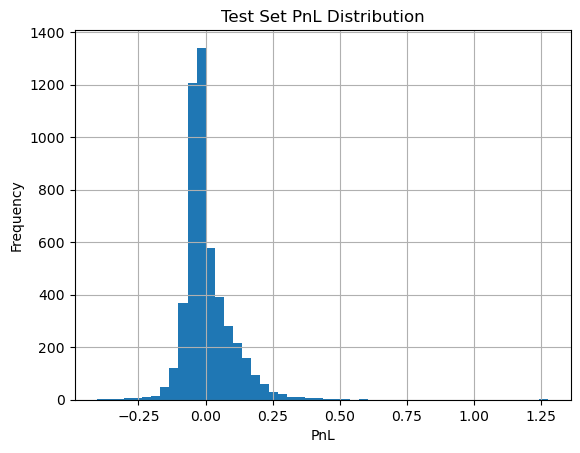

In [34]:
plt.hist(test_result["pnl"].numpy(), bins=50)
plt.title("Test Set PnL Distribution")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

ValueError: too many values to unpack (expected 2)